# 201601615 이의찬

# 1. 지정 주제

## 영화: 외계+인 1부

먼저 기술적인 이유는 '외계+인 1부'가 사람들의 호불호가 갈리고 의견의 대립이 첨예하기 때문이다. <br>
원래 선정한 인생영화는 인터스텔라와 위플래쉬였으나 인터스텔라는 평이 너무 좋고 평점이 낮은 리뷰에는 댓글이 잘 달리지 않아서 극적인 결과를 확인하기 힘들었고 위플래쉬는 일반적인 '재미없다'라는 평보다 광기, 싸이코패스 등 일반적이지 않은 평이 많아서 분류기 학습시킨 결과가 아쉬웠기 때문에 좋은 평가와 안 좋은 평가가 골고루 있는 영화 '외계+인 1부'를 선정하게 되었다. 

개인적인 이유는 최근에 'her'라는 영화를 보고 머리를 비우고 싶어서 본 영화이다. 영화를 보기 전에 기대를 하지 않고 봤었고 한국 영화에 드문 참신한 컨셉이 재밌었고 딱 떨이지는 스토리도 좋았다. 인생영화라고 하기엔 2부까지 나와봐야 알겠지만 최근에 재밌게 봐서 선정해 보았다.

In [133]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By # find_element 를 할 때, 속성값 관리
from selenium.webdriver.common.keys import Keys
from urllib.request import urlopen
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from collections import Counter
from konlpy.tag import Okt
from nltk.tokenize import word_tokenize
from urllib.request import urlopen
from threading import Thread
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import urllib
import time

okt = Okt()

POS = 9
NEG = 4

In [134]:
driver_path = "chromedriver.exe" # 경로명: 현재 폴더로 되어있음
movie_url = r"https://movie.daum.net/moviedb/grade?movieId=139606" # '다음 영화' url

### selenium 드라이버

In [135]:
driver = webdriver.Chrome(driver_path)
driver.implicitly_wait(3) # 열리는 시간 3초 대기
driver.get(movie_url)

C:\Users\outda\AppData\Local\Temp\ipykernel_15264\3252897723.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(driver_path)


## 1. 영화 리뷰 가져오기

### 다음 영화 리뷰 전부 로드하기

- `user_count`: 평점을 남긴 유저 수(평점 더보기 버튼 누를 횟수 계산할 때 사용) <br>
- `more_count`: 더보기 버튼 누르는 횟수<br>
- `more_button`: 더보기 버튼<br>

In [136]:
# 유저 수
user_count = driver.find_element(
    By.CLASS_NAME, "txt_netizen"
).text.strip("()명") 

# 더보기 버튼 누르는 횟수
more_count = (int(user_count) - 10) // 30 + 1 

# 더보기 버튼
more_button = '//*[@id="alex-area"]/div/div/div/div[3]/div[1]/button' 

# 더보기 버튼 클릭
for i in tqdm(range(more_count)):
    driver.find_element(By.XPATH, more_button).click()
    time.sleep(2)

  0%|          | 0/53 [00:00<?, ?it/s]

### html에서 리뷰 데이터(댓글, 평점) 추출

- `reviews`
    - 타입: list<tuple<댓글: string, 평점: int>>
    - 유저들이 남긴 리뷰를 댓글과 평점으로만 저장
    
    
- `html`
    - `driver.page_source`를 사용하여 현재 `selenium`으로 렌더링 된 페이지의 모든 `Elements`를 모두 가져오고 selenium으로 작업한 url 정보를 html로 가져온다.

In [139]:
html = driver.page_source

# with open('inter_review_data.txt', 'r', encoding='utf-8') as f:
#     html = f.read()
#     f.close()

soup = BeautifulSoup(html, "html.parser")

# 리뷰 div
div_reviews = soup.find_all("div", {"class": "cmt_info"})

# 유저 리뷰(댓글, 평점)
reviews = []

for div_review in div_reviews:
    # 댓글 p
    comment = div_review.find("p", {"class": "desc_txt font_size_"}) 
    
    if not comment:
        # 댓글을 적지 않고 평점만 줬다면 무시
        continue
        
    comment = comment.text.strip() # 댓글
    rating = int(div_review.find("div").text) # 평점 div
    
    reviews.append((comment, rating))

  0%|          | 0/1578 [00:00<?, ?it/s]

## 2. 워드 클라우드 그리기

#### 함수

- `okt_pos_by_filter(text:str, filter:list)`
    - okt를 이용하여 문장을 단어로 분리하고 단어를 필터링하는 함수
    - filter 기본값: 명사(Noun), 동사(Verb), 형용사(Adjective)
    
    
- `remove_meaningless_words(words:Counter)`
    - 의미없는 단어를 제거하는 함수
    - 한 글자 단어 삭제
    - 데이터로써 의미없는 동사 삭제
    
    
- `generate_wc_frequencies(word_count:Counter)`
    - 워드클라우드 단어 빈도수 객체 반환

In [140]:
# 환경에 따라 재설정 필요
font_path = r'C:\Windows\Fonts\gulim.ttc'

def okt_pos_by_filter(text:str, filter=['Noun', 'Verb', 'Adjective']):
    result = []
    for t in okt.pos(text, norm=True, stem=True):
        if t[1] in filter:
            result.append(t[0])
            
    return result

def remove_meaningless_words(words:Counter):
    '''의미없는 단어 삭제하는 함수'''
    # 한 글자로 이루어진 단어 제거
    stopword_list = []
    
    for word in words:
        if len(word) == 1:
            stopword_list.append(word)

    for stopword in stopword_list:
        words.pop(stopword)

    # 의미없는 동사 제거
    verbs = [
        '하다', '보다', '있다', '되다', '이다', 
        '이렇다', '그렇다', '이겠다'
    ]
    
    for v in verbs:
        if v in words:
            words.pop(v)
    
    return words

def generate_wc_frequencies(word_count:Counter):
    '''워드 클라우드 빈도수 객체 생성'''
    wc = WordCloud(
        background_color='white', 
        max_words=5000, 
        font_path=font_path, 
        colormap='seismic'
    )
    return wc.generate_from_frequencies(word_count)

### 2-1. 전체, 긍정, 부정 평가 단어 처리하기

- `all_comment_words`
- `pos_comment_words`
- `neg_comment_words`

In [141]:
# 댓글의 명사, 동사, 형용사만 추출
all_comment_words = []
pos_comment_words = []
neg_comment_words = []

for review in tqdm(reviews):
    comment = review[0].replace("\n", " ")
    rating = review[1]
    
    all_comment_words += okt_pos_by_filter(comment)
    if rating >= POS: 
        pos_comment_words += okt_pos_by_filter(comment)
        
    elif rating <= NEG: 
        neg_comment_words += okt_pos_by_filter(comment)
        
all_comment_words = Counter(all_comment_words)
all_comment_words = remove_meaningless_words(all_comment_word)

pos_comment_words = Counter(pos_comment_words)
pos_comment_words = remove_meaningless_words(pos_comment_word)

neg_comment_words = Counter(neg_comment_words)
neg_comment_words = remove_meaningless_words(neg_comment_word)    

  0%|          | 0/1565 [00:00<?, ?it/s]

### 2-3. 워드 클라우드

#### 2-3-1. 전체

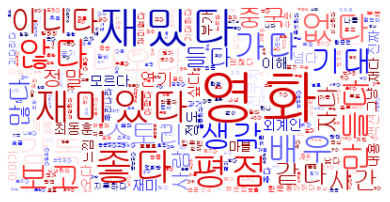

In [142]:
all_wc = generate_wc_frequencies(all_comment_words)
plt.imshow(all_wc, interpolation="bilinear")
plt.axis('off') # 테두리 제거
plt.show()

#### 2-3-2. 전체 결과 해석

전체적으로 재미있다, 좋다라는 평이 많고 타짜, 감독이라는 글자가 큰 이유는 타짜, 도둑들 같은 흥행 작품을 했던 유명한 감독이라서 '감독'이라는 키워드가 자주 언급된 것으로 보인다. 

#### 2-3-3. 긍정 리뷰 워드 클라우드

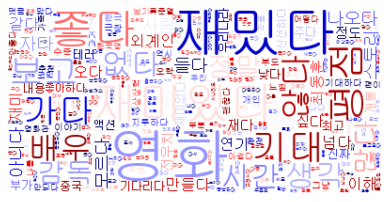

In [143]:
pos_wc = generate_wc_frequencies(pos_comment_words)
plt.imshow(pos_wc, interpolation="bilinear")
plt.axis('off') # 테두리 제거
plt.show()

#### 2-3-4. 부정 리뷰 워드 클라우드

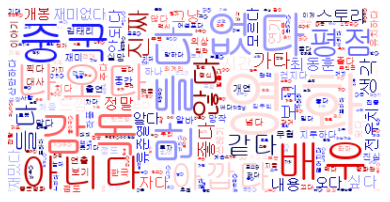

In [144]:
neg_wc = generate_wc_frequencies(neg_comment_words)
plt.imshow(neg_wc, interpolation="bilinear")
plt.axis('off') # 테두리 제거
plt.show()

#### 2-3-4. 긍정 리뷰, 부정 리뷰 결과 해석, 비교

## 3. 분류기 학습시키기

#### 함수

In [68]:
def load_data(file_path):
    train = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            line = line.strip()
            id, doc, label = line.split('\t')
            if label == '1': 
                label = 'pos'
            elif label == '0': 
                label = 'neg'
            train.append((doc, label))
    return train

def format_data(reviews):
    train = []
    
    for review in reviews:
        comment = review[0].replace("\n", " ")
        if len(comment) > 140:
            continue
            
        rating = review[1]
        
        if rating >= POS:
            label = 'pos'
        elif rating <= NEG:
            label = 'neg'
        else:
            continue
        
        train.append((comment, label))
        
    return train

def pos_tokenize(raw_sent):
    pos_sent = []
    sent = okt.pos(raw_sent, norm=True, stem=True)
    for tup in sent:
        word, tag = tup[0], tup[1]
        word_tag = word + '/' + tag
        pos_sent.append(word_tag)
    return ' '.join(pos_sent)

def make_word_dict(train, use_morph=False):
    all_words = set()
    
    for tup in tqdm(train):
        sent, label = tup[0], tup[1]
        if use_morph:
            sent = pos_tokenize(sent)
        words = word_tokenize(sent)
        for word in words:
            all_words.add(word)
    return all_words

def make_train_feats(train, all_words, use_morph=False):
    train_features = []
    
    for tup in tqdm(train):
        sent, label = tup[0], tup[1]
        if use_morph:
            sent = pos_tokenize(sent)
        words = word_tokenize(sent)
        tmp = {set_word: (set_word in words) for set_word in all_words}
        sent_tup = (tmp, label)
        train_features.append(sent_tup)
    return train_features

In [69]:
train = format_data(reviews)

In [70]:
use_morph = True
all_words = make_word_dict(train, use_morph)
train_feature = make_train_feats(train, all_words, use_morph)

  0%|          | 0/1117 [00:00<?, ?it/s]

  0%|          | 0/1117 [00:00<?, ?it/s]

In [71]:
classifier = nltk.NaiveBayesClassifier.train(train_feature)
classifier.show_most_informative_features()

Most Informative Features
          재미있다/Adjective = True              pos : neg    =     31.2 : 1.0
                 졸다/Verb = True              neg : pos    =     15.1 : 1.0
                 재다/Verb = True              pos : neg    =     15.1 : 1.0
           재밌다/Adjective = True              pos : neg    =     14.9 : 1.0
                 점도/Noun = True              neg : pos    =     12.5 : 1.0
                 부가/Noun = True              pos : neg    =     11.0 : 1.0
            낮다/Adjective = True              pos : neg    =     10.3 : 1.0
                 중간/Noun = True              neg : pos    =      9.8 : 1.0
                  해/Noun = True              neg : pos    =      9.8 : 1.0
           아깝다/Adjective = True              neg : pos    =      9.1 : 1.0


In [72]:
sents = load_data('ratings_test.txt')

count = 2000
matches_count = 0

for i in tqdm(range(1, count)):
    test_sent = sents[i][0]
    comment = test_sent
    test_sent = pos_tokenize(test_sent)
    words = word_tokenize(test_sent)
    test_feature = {set_word: (set_word in words) for set_word in all_words}
    
    if sents[i][1] == classifier.classify(test_feature):
        matches_count += 1
        
print('일치하는 비율: ', (matches_count/count)*100)

  0%|          | 0/1999 [00:00<?, ?it/s]

일치하는 비율:  67.75


In [73]:
test_sent = "졸다가 나왔음"
test_sent = pos_tokenize(test_sent)
words = word_tokenize(test_sent)
test_feature = {set_word: (set_word in words) for set_word in all_words}
print(classifier.classify(test_feature))

neg


In [74]:
nltk.classify.accuracy(classifier, train_feature)

0.9650850492390332

## 4. 지정 주제 느낀 점 및 자기 평가

# 자유주제

내가 재밌게 본 영화를 재밌게 본 사람의 다른 재밌는 영화

In [112]:
def get_high_rated_movies(id, start, end, searched, result):
    '''다른 사람 리뷰 중 높은 점수를 준 영화 크롤링'''
    if start == 0:
        start = 1
        
    for page in tqdm(range(start, end)):
        url = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.naver' + \
        f'?code=192151&type=after&onlyActualPointYn=N&onlySpoilerPointYn=N&order=highest&page={page}'

        html = urlopen(url)
        soup = BeautifulSoup(html.read(), "html.parser")

        div_reviews = soup.find('div', {'class': 'score_result'})
        li_reviews = div_reviews.find_all('li')

        for li_review in li_reviews:
            rating = int(li_review.find('div', {'class': 'star_score'}).text.strip())
            div_reple = li_review.find('div', {'class': 'score_reple'})
            dl = div_reple.find('dl')
            user_unique_id = dl.find('a')['onclick'][30:38]

            if rating < 8:
                continue

            nick_url = 'https://movie.naver.com/movie/point/af/list.naver?st=nickname&target=after&sword=' + user_unique_id
            nick_html = urlopen(nick_url)
            nick_soup = BeautifulSoup(nick_html.read(), "html.parser")
            reviews = nick_soup.find_all('td', {'class': 'title'})
            for review in reviews:
                title = review.find('a', {'class': 'movie color_b'}).text

                if title == searched:
                    continue

                score = review.find(
                    'div', {'class': 'list_netizen_score'}
                ).find('em').text

                if int(score) < 8:
                    continue
                    
                if not title in result:
                    result[title] = {
                        'total': 0,
                        '10': 0,
                        '9': 0,
                        '8': 0
                    }
                
                result[title][score] += 1
                result[title]['total'] += 1

In [128]:
# 평점 높은 순 버튼 클릭
result = dict()
my_title = '외계+인 1부'
threads = []
interval = 30

for i in range(1, 4):
    th = Thread(
        target=get_high_rated_movies, 
        args=(i+1,(i-1)*interval, i*interval, my_title, result)
    )
    th.start()
    threads.append(th)
    
for thread in threads:
    thread.join()

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [129]:
# # html 텍스트 파일 저장 코드
# text_file = open('free.txt', 'w', encoding='utf-8')
# text_file.write(str(dict(sorted(result.items(), key=lambda item: item[1]['10'], reverse=True))))
# text_file.close()
# # print(titles)

In [130]:
# with open('free.txt', 'r', encoding='utf-8') as f:
#     import ast
#     data = f.read()
#     result = ast.literal_eval(data)
#     f.close()

In [131]:
df = pd.DataFrame(result).T
df.columns = ['총합', '10점', '9점', '8점']
df = df.sort_values('총합', ascending=False)
df_top_15 = df[:15]
df_top_15

,총합,10점,9점,8점
헌트,29,22,2,5
범죄도시2,27,22,0,5
변호인,24,24,0,0
한산: 용의 출현,23,19,2,2
비상선언,19,15,1,3
올빼미,18,15,1,2
마녀(魔女) Part2. The Other One,17,15,1,1
탑건: 매버릭,16,15,0,1
백두산,15,11,1,3
카터,13,11,0,2


<AxesSubplot:>

<Figure size 1440x720 with 0 Axes>

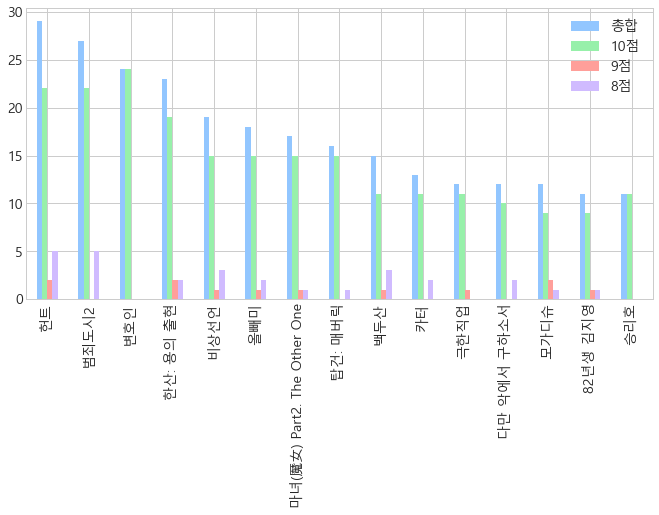

In [132]:
plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(20, 10))
plt.style.use('seaborn-pastel')
df_top_15.plot(kind='bar', figsize=(10,5))